

# Practical 5b: Generative Adversarial Network

© Machine Learning Summer School - Telkom University

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%205/MLSS2020TU%20-%20Practical%205b.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
    
</td><td>
<a href="https://github.com/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%205/MLSS2020TU%20-%20Practical%205b.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>

# Generative Adverserial Network


In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). 

As you've tried before, another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with Variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

<br>

Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train 


Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! 2017 is said to be the year of GAN with so many research and papers published in investigating and improving GANs application. 

Several popular GAN architectures and implementation are: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028), [CGAN](https://arxiv.org/abs/1411.1784), [InfoGAN](https://arxiv.org/abs/1606.03657), [Pix2Pix](https://arxiv.org/abs/1611.07004), [CycleGAN](https://arxiv.org/abs/1703.10593), and many others.

---
## GAN Networks

In a GAN, we build two different neural networks. 

Our first network is a traditional classification network, called the **DISCRIMINATOR**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). 

Our other network, called the **GENERATOR**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

<center>
<img src="https://i.ibb.co/4RyZ2Vr/gan-en.png" width=80% />
</center>
<br>

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where 
* $z \sim p(z)$ are the random noise samples,
* $G(z)$ are the generated images using the neural network generator $G$, and
* $D$ is the output of the discriminator, specifying the probability of an input being real.

<br>

In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

---
# [Part 0] Import Libraries and Load Data

---
## Import Libraries

Import requiered libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import os, time, glob, imageio, PIL
from IPython.display import Image


os.mkdir('imgs')

---
## Load MNIST Dataset

Again, here we're going to use the simple MNIST Dataset. You can try with other MNIST-like dataset like before.

Also, we don't really need the test split in GAN, so here we combine them

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


X_train = np.concatenate([X_train, X_test])

11493376/11490434 [==============================] - 0s 0us/step



It is recommended to use the **hyperbolic tangent** activation function as the output from the generator model.

As such, it is also recommended that real images used to train the discriminator are scaled so that their pixel values are in the range `[-1,1]`. This is so that the discriminator will always receive images as input, real and fake, that have pixel values in the same range.

In [3]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]

---
## Helper Functions

Combine array of images into one image side-by-side, then normalize back into $[0..255]$ range

In [4]:
def combine_images(images):
    num = images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=images.dtype)
    for index, img in enumerate(images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    image = image*127.5+127.5   
    
    return image

Generate and save images

In [5]:
def generate_images(generator, batch_size, sampling='normal'):

    z_size = generator.layers[0].input_shape[1]    
    if sampling == 'normal':
        noise = tf.random.normal(shape=(batch_size, z_size))
    else:
        noise = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)

    generated_images = generator.predict(noise, verbose=1)

    image = combine_images(generated_images)

    filename = "generated_image.png"
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)

    return image

Generate and save better images

In [6]:
def generate_best_images(generator, discriminator, batch_size, sampling='normal', tries=20):

    z_size = generator.layers[0].input_shape[1]    
    if sampling == 'normal':
        noise = tf.random.normal(shape=(batch_size*tries, z_size))
    else:
        noise = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)
            

    generated_images = generator.predict(noise, verbose=0)
    d_pret = discriminator.predict(generated_images, verbose=0)

    index = np.arange(0, batch_size*tries)
    index.resize((batch_size*tries, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)

    filename = "generated_image_best.png"
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)

    return image

Functions to animate saved image during training

In [7]:
def show_gif(base_dir, anim_file): 

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(base_dir+'/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            for i in range(3):
                writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

    print('GIF saved as', anim_file)

    with open(anim_file,'rb') as f:
        display(Image(data=f.read(), format='png'))

---
# [Part 1] GAN Training
Inside the training loop, there are basically three steps to train GANs.


<center>
<img src="https://i.ibb.co/Y388bJb/gan-steps-en.png" width=80% />
</center>
<br>

First, in each iteration, we use the current Generator to generate new batch of fake data from random latent space. Then the second is we use the generated batch along with a real batch of data to train one step of the Discriminator Model (one time forward and backward pass). The objective here is to minimize the binary crossentropy loss between the fake and real class.

The last is to train the Generator Model by feeding in a batch of random latent space to generate a batch of fake data (forward pass). The batch of fake data then feed into the trained Discriminator from previous step (forward pass). The objective here is to maximize the wrongly classified data, which we can turn into minimizing correctly classified data. The loss is then used to update **ONLY** the Generator Model's weights (backward pass)


---
##1 - Define Models

As mentioned before, there are two networks inside GAN, namely Generator and Discriminator.

As a side note, The rectified linear activation unit, or ReLU for short, is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less.

It has become a best practice when developing deep convolutional neural networks generally, which it's also implemented in this exmaple.

However, best practice for GANs is to use a variation of the ReLU that allows some values less than zero and learns where the cut-off should be in each node. This is called the leaky rectified linear activation unit, or LeakyReLU for short. You can try and change the activation function yourself.


### Generator Model

The generator model must generate an output image given as input at a random point from the latent space.

The recommended approach for achieving this is to use a transpose convolutional layer with a strided convolution. This is a special type of layer that performs the convolution operation in reverse. 

Intuitively, this means that setting a stride of $2×2$ will have the opposite effect, upsampling the input instead of downsampling it in the case of a normal convolutional layer.


<center>
<img src="https://i.ibb.co/s2gX3jR/generator1.png" width=70% />
</center>


By stacking a transpose convolutional layer with strided convolutions, the generator model is able to scale a given input to the desired output dimensions. It is also recommended in using Batch Normalization to standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

In [8]:
def generator_model(latent_dim = 128):
    model = Sequential([
        Dense(1024, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dense(7 * 7 * 128, activation='relu'),
        Reshape((7, 7, 128)),
        Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', activation='tanh'),
    ])
    return model

generator_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1

### Discriminator Model

The discriminator model is a standard convolutional neural network model that takes an image as input and must output a binary classification as to whether it is real or fake.


<center>
<img src="https://i.ibb.co/nnxBg8S/discriminator1.png" width=70% />
</center>


It is standard practice with deep convolutional networks to use pooling layers to downsample the input and feature maps with the depth of the network, like implemented below.

However, turns out this is not recommended for the DCGAN, and instead, they recommend downsampling using strided convolutions. You can try and change the `maxpool` below using strided convolution yourself.

In [9]:
def discriminator_model():
    model = Sequential([
        Conv2D(32, (5, 5), input_shape=(28, 28, 1), padding='same'),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (5, 5)),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4 * 4 * 64, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

### GAN = Generator + Discriminator

In [10]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

---
## 2 - Training Functions

The latent space defines the shape and distribution of the input to the generator model used to generate new images.

The DCGAN recommends sampling from a uniform distribution, meaning that the shape of the latent space is a hypercube.

The more recent best practice is to sample from a standard Gaussian distribution, meaning that the shape of the latent space is a hypersphere, with a mean of zero and a standard deviation of one.

Tom White's [Sampling Generative Networks](https://arxiv.org/abs/1609.04468), ref code https://github.com/dribnet/plat has more details

---
The discriminator model is trained using stochastic gradient descent with mini-batches.

The best practice is to update the discriminator with separate batches of real and fake images rather than combining real and fake images into a single batch.

This can be achieved by updating the model weights for the discriminator model with two separate calls to the `train_on_batch()` function. You can try and change this yourself.

---
It is common to use the class label 1 to represent real images and class label 0 to represent fake images when training the discriminator model.

These are called hard labels, as the label values are precise or crisp.

It is a good practice to use soft labels as mentioned by Salimans et. al. 2016. Such values are slightly more or less than 1.0 or slightly more than 0.0 for real and fake images respectively, where the variation for each image is random.

This is often referred to as label noise or smoothing and can have a regularizing effect when training the model.

In [11]:
def train_gan(X_train, Y_train, 
              batch_size, epochs, 
              models, sampling='normal',
              save_every=500, print_every=100):    

    def sampling_fn(shape):
        if sampling == 'normal':
            return tf.random.normal(shape)
        else:
            return tf.random.uniform(shape, minval=-1, maxval=1)


    g, d, d_on_g = models


    print('Start training using random', sampling, 'distribution')
    print('Number of batches', int(X_train.shape[0]/batch_size))

    z_size = g.layers[0].input_shape[1]
    seed_saved = sampling_fn(shape=(16, z_size))
    img_count = 0

    start = time.time()

    for epoch in range(epochs):
        print("\n-------------------------------\nEpoch is", epoch)        
        
        for index in range(int(X_train.shape[0]/batch_size)):
            
            noise = sampling_fn(shape=(batch_size, z_size))
            
            generated_images = g.predict(noise, verbose=0)
            
            image_batch = X_train[index*batch_size:(index+1)*batch_size]
            
            if index % save_every == 0:
                for_save = g.predict(seed_saved)
                image = combine_images(for_save)     

                plt.imshow(image, cmap=plt.get_cmap('gray'))
                filename = 'imgs/image_'+'{:03}'.format(img_count)+'.png'
                plt.axis('off')
                plt.savefig(filename)
                plt.show()
                img_count += 1
                
            X = np.concatenate((image_batch, generated_images))
            y = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            y += 0.05 * tf.random.uniform(tf.shape(y))
            
            d_loss = d.train_on_batch(X, y)           
            
            noise = sampling_fn(shape=(batch_size, z_size))
            
            d.trainable = False            
            y = tf.ones((batch_size, 1))
            g_loss = d_on_g.train_on_batch(noise, y)
            
            if index % print_every == 0: 
                print("batch %d, g_loss : %f, d_loss : %f" % (index, g_loss, d_loss))
            
            d.trainable = True       
            
    end = time.time()

    print('Training ended in', (end-start)/60, 'minutes')
    models = [g, d, d_on_g]
        
    return models

---
##3 - Training Process

---
### Initialize Models

In [12]:
g_model = generator_model()
d_model = discriminator_model()

---
### Compile Models

Stochastic gradient descent, or SGD for short, is the standard algorithm used to optimize the weights of convolutional neural network models.

There are many variants of the training algorithm. The best practice for training DCGAN models is to use the Adam version of stochastic gradient descent with the learning rate of $2e^{-4}$ or $3e^{-4}$  and the beta1 momentum value of 0.5 instead of the default of 0.9.

The Adam optimization algorithm with this configuration is recommended when both optimizing the discriminator and generator models.

In [13]:
d_optim = Adam(learning_rate=0.0003, beta_1=0.5)
g_optim = Adam(learning_rate=0.0003, beta_1=0.5)

d_model.trainable = False 
d_on_g = combine_model(g_model, d_model)
d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)

d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=d_optim)

models = [g_model, d_model, d_on_g]

### Train GAN

In [14]:
batch = 225
epochs = 50
g_model, d_model, _ = train_gan(X_train, y_train, batch, epochs, models)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
show_gif('imgs', 'GAN.gif')

Output hidden; open in https://colab.research.google.com to view.

---
## 4 - Generate New Images

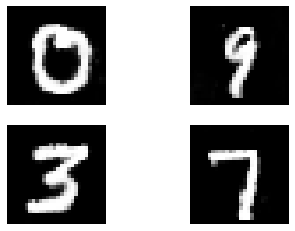

In [16]:
seed = tf.random.normal(shape=(4, 128))
images = g_model.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 2ms/step


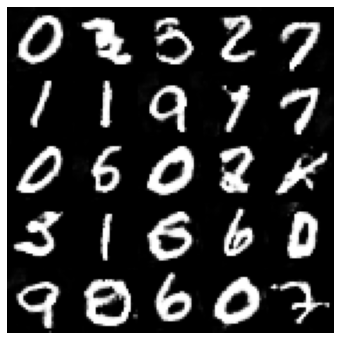

In [17]:
images = generate_images(g_model, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

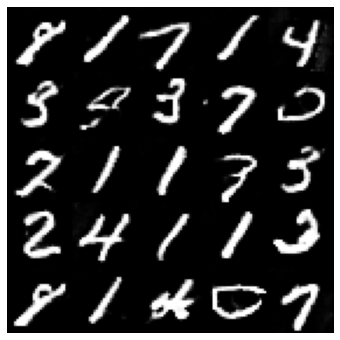

In [18]:
images = generate_best_images(g_model, d_model, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

---

# Congratulation

<font size=5> You've Completed Practical 5b</font>

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>